# Relation Extraction with a BERT Model over RareDis Dataset

In this project, there are developed the necessary steps to deploy a Bidirectional Encoder Representations from Transformers (BERT) model to extract and classify relations between words from the RareDis dataset.

## 1. Connection with the cloud files

First of all, it is necessary to activate Google Drive in the execution environment (it is also possible to execute `drive.flush_and_unmount()` to unmount the current session, if it is established previously).

In [1]:
#drive.flush_and_unmount() # Optional, only if necessary
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The next step is optional, it is only for checking purpose to test the correct connection with Google Drive and see the current files. It also serves to define a path to work on.

In [2]:
root = '/content/drive/My Drive/Colab Notebooks'
#!ls '/content/drive/My Drive/Colab Notebooks'
print("Current directory: {}".format(root))

Current directory: /content/drive/My Drive/Colab Notebooks


For execution purposes, it is recommendable to ensure that TensorFlow uses GPU. 
In the following some layers will choose different implementations (cuDNN-based or pure-TensorFlow) to maximize the performance. If a GPU is available and all the arguments to the layer meet the requirement of the CuDNN kernel (see each layer separately), the layer will use a fast cuDNN implementation.
Currently, GRU layer supports CuDNN.

In [3]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

# If not working try
#!pip install tensorflow==2.1.0

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12295442876523702276
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11345264640
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5780671875760088364
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]
Default GPU Device: /device:GPU:0


If TensorBoard is to be used, this cell is required. It includes the use of the `tensorboard.notebook` APIs for a bit more control if desired.

In [4]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

from tensorboard import notebook
notebook.list() # View open TensorBoard instances

# Control TensorBoard display. If no port is provided, the most recently launched TensorBoard is used
#notebook.display(port=6006, height=1000)

No known TensorBoard instances running.


## 2. Reading and preprocessing of the dataset

Here, the execution of the actual code is started. At first, all the necessary libraries to deploy the structure are imported for Python.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras import optimizers, losses, metrics
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, ConfusionMatrixDisplay
import spacy #NLP library for sentence segmentation and tokenization
nlp = spacy.load("en_core_web_sm")
pd.set_option('max_colwidth', None)

After this, the RareDis dataset is readed into a Pandas DataFrame using some data manipulation techniques. For this task, it is necessary to keep the "Sentences" and "Labels" as columns of the resulting dataset.



In [6]:
# Definition of Train & Test Paths
path_train = root + '/relation_extraction/data/gold_nlp4rare_corpus/train.csv'
path_dev = root + '/relation_extraction/data/gold_nlp4rare_corpus/dev.csv'
path_test = root + '/relation_extraction/data/gold_nlp4rare_corpus/test.csv'

# Read of all the datasets
RareDis_df_train = pd.read_csv(path_train)
RareDis_df_train.drop(columns=['Unnamed: 0'], inplace=True)

RareDis_df_dev = pd.read_csv(path_dev)
RareDis_df_dev.drop(columns=['Unnamed: 0'], inplace=True)

RareDis_df_test = pd.read_csv(path_test)
RareDis_df_test.drop(columns=['Unnamed: 0'], inplace=True)

In [7]:
RareDis_df_dev

,Sentence,Relation,e1,e2
0,Cat eye syndrome (CES) is a rare chromosomal disorder that may be evident at birth.,Is_a,Cat eye syndrome,chromosomal disorder
1,Cat eye syndrome (CES) is a rare chromosomal disorder that may be evident at birth.,Is_acron,CES,Cat eye syndrome
2,Additional chromosomal disorders may have features similar to those associated with Chromosome 14 Ring.,Is_a,chromosomal disorders,chromosomal disorder
3,"Chromosome 9 Ring may also be characterized by additional physical features in some cases, including growth retardation, heart defects, genital abnormalities, and/or other findings.",Produces,Chromosome 9 Ring,growth retardation
4,"Chromosome 9 Ring may also be characterized by additional physical features in some cases, including growth retardation, heart defects, genital abnormalities, and/or other findings.",Produces,Chromosome 9 Ring,heart defects
...,...,...,...,...
254,"Patients may present with symptoms associated with low blood calcium (hypocalcemia) such as muscle weakness, tetany, and convulsions, or findings related to kidney disease such as proteinuria, hematuria, and nephrotic syndrome.",Produces,nephrotic syndrome,kidney disease
255,"Patients may present with symptoms associated with low blood calcium (hypocalcemia) such as muscle weakness, tetany, and convulsions, or findings related to kidney disease such as proteinuria, hematuria, and nephrotic syndrome.",Produces,nephrotic syndrome,proteinuria
256,"Patients may present with symptoms associated with low blood calcium (hypocalcemia) such as muscle weakness, tetany, and convulsions, or findings related to kidney disease such as proteinuria, hematuria, and nephrotic syndrome.",Produces,nephrotic syndrome,hematuria
257,"Patients may present with symptoms associated with low blood calcium (hypocalcemia) such as muscle weakness, tetany, and convulsions, or findings related to kidney disease such as proteinuria, hematuria, and nephrotic syndrome.",Produces,nephrotic syndrome,nephrotic syndrome


Mapping the labels per integers is the first step to apply one hot encoding afterwards. For this step, we group the categories into the different possible relations.

In [8]:
labels_dict = {'Produces': 0,
               'Increases_risk_of': 1,
               'Is_a': 2,
               'Is_acron': 3,
               'Is_synon': 4,
               }
RareDis_df_train["Relation"] = RareDis_df_train["Relation"].map(labels_dict)
RareDis_df_dev["Relation"] = RareDis_df_dev["Relation"].map(labels_dict)
RareDis_df_test["Relation"] = RareDis_df_test["Relation"].map(labels_dict)

In [9]:
RareDis_df_dev

,Sentence,Relation,e1,e2
0,Cat eye syndrome (CES) is a rare chromosomal disorder that may be evident at birth.,2,Cat eye syndrome,chromosomal disorder
1,Cat eye syndrome (CES) is a rare chromosomal disorder that may be evident at birth.,3,CES,Cat eye syndrome
2,Additional chromosomal disorders may have features similar to those associated with Chromosome 14 Ring.,2,chromosomal disorders,chromosomal disorder
3,"Chromosome 9 Ring may also be characterized by additional physical features in some cases, including growth retardation, heart defects, genital abnormalities, and/or other findings.",0,Chromosome 9 Ring,growth retardation
4,"Chromosome 9 Ring may also be characterized by additional physical features in some cases, including growth retardation, heart defects, genital abnormalities, and/or other findings.",0,Chromosome 9 Ring,heart defects
...,...,...,...,...
254,"Patients may present with symptoms associated with low blood calcium (hypocalcemia) such as muscle weakness, tetany, and convulsions, or findings related to kidney disease such as proteinuria, hematuria, and nephrotic syndrome.",0,nephrotic syndrome,kidney disease
255,"Patients may present with symptoms associated with low blood calcium (hypocalcemia) such as muscle weakness, tetany, and convulsions, or findings related to kidney disease such as proteinuria, hematuria, and nephrotic syndrome.",0,nephrotic syndrome,proteinuria
256,"Patients may present with symptoms associated with low blood calcium (hypocalcemia) such as muscle weakness, tetany, and convulsions, or findings related to kidney disease such as proteinuria, hematuria, and nephrotic syndrome.",0,nephrotic syndrome,hematuria
257,"Patients may present with symptoms associated with low blood calcium (hypocalcemia) such as muscle weakness, tetany, and convulsions, or findings related to kidney disease such as proteinuria, hematuria, and nephrotic syndrome.",0,nephrotic syndrome,nephrotic syndrome


## 3. Building the BERT Model

The BERT (Bidirectional Encoder Representations from Transformers) model is a bidirectional transformer pre-trained using a combination of masked language modeling objective and next sentence prediction on a large corpus comprising the Toronto Book Corpus and Wikipedia.
The unsupervised tasks like next sentence prediction on which BERT is trained allows us to use a pre-trained BERT model by fine-tuning the same on downstream specific tasks.
The models are based in Google Research pre-trained models, available [here](https://github.com/google-research/bert).

- For this task, which can be catalogued as a classification task, it is used a `TFBertForSequenceClassification` model with a `bert-base-uncased` pre-trained model. This model uses a concatenation of `TFBertMainLayer` plus a `Dropout` layer plus a `Dense` layer. Source code: [here](https://huggingface.co/transformers/_modules/transformers/models/bert/modeling_tf_bert.html#TFBertForSequenceClassification).
- A complete list of all models can be found [here](https://huggingface.co/transformers/model_doc/bert.html).
- A complete list of all pre-trained models can be found [here](https://huggingface.co/transformers/pretrained_models.html).

The processes of tokenization involve splitting the input text into a list of tokens that are available in the vocabulary. In order to deal with the words not available in the vocabulary, BERT uses a technique called BPE based WordPiece tokenization. In this approach, an out of vocabulary word is progressively split into subwords and the word is then represented by a group of subwords. Since the subwords are part of the vocabulary, we have learned representations a context for these subwords and the context of the word is simply the combination of the context of the subwords.

In [10]:
# Required configuration and imports
!pip install transformers
from transformers import BertTokenizer, TFBertModel, BertConfig, TFBertForSequenceClassification
from transformers import AdamWeightDecay # Optional optimizer if desired

     |████████████████████████████████| 2.8 MB 5.4 MB/s 
     |████████████████████████████████| 636 kB 40.7 MB/s 
     |████████████████████████████████| 50 kB 6.1 MB/s 
     |████████████████████████████████| 3.3 MB 36.7 MB/s 
     |████████████████████████████████| 895 kB 36.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [11]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD" -O biobert_weights && rm -rf /tmp/cookies.txt

--2021-09-05 11:26:52--  https://docs.google.com/uc?export=download&confirm=FuAc&id=1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD
Resolving docs.google.com (docs.google.com)... 172.253.114.138, 172.253.114.102, 172.253.114.100, ...
Connecting to docs.google.com (docs.google.com)|172.253.114.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-2o-docs.googleusercontent.com/docs/securesc/55ed5d7rtihp78hpm1i7lumk5a88ka9b/j1ptcnta0kfah2ii5aapigtmetrndiq7/1630841175000/13799006341648886493/10733025637270651602Z/1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD?e=download [following]
--2021-09-05 11:26:52--  https://doc-04-2o-docs.googleusercontent.com/docs/securesc/55ed5d7rtihp78hpm1i7lumk5a88ka9b/j1ptcnta0kfah2ii5aapigtmetrndiq7/1630841175000/13799006341648886493/10733025637270651602Z/1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD?e=download
Resolving doc-04-2o-docs.googleusercontent.com (doc-04-2o-docs.googleusercontent.com)... 172.217.214.132, 2607:f8b0:4001:c05::84
Conne

In [12]:
!tar -xzf biobert_weights
!ls biobert_v1.1_pubmed/

bert_config.json			model.ckpt-1000000.index  vocab.txt
model.ckpt-1000000.data-00000-of-00001	model.ckpt-1000000.meta


In [13]:
!transformers-cli convert --model_type bert --tf_checkpoint biobert_v1.1_pubmed/model.ckpt-1000000 --config biobert_v1.1_pubmed/bert_config.json --pytorch_dump_output biobert_v1.1_pubmed/tf_model.h5

Building PyTorch model from configuration: BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.10.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

Converting TensorFlow checkpoint from /content/biobert_v1.1_pubmed/model.ckpt-1000000
Loading TF weight bert/embeddings/LayerNorm/beta with shape [768]
Loading TF weight bert/embeddings/LayerNorm/gamma with shape [768]
Loading TF weight bert/embeddings/position_embeddings with shape [512, 768]
Loading TF weight bert/embeddings/token_type_embeddings with shape [2, 768]
Loading TF weight bert/emb

In [14]:
!ls biobert_v1.1_pubmed/
!mv biobert_v1.1_pubmed/bert_config.json biobert_v1.1_pubmed/config.json
!ls biobert_v1.1_pubmed/

bert_config.json			model.ckpt-1000000.index  tf_model.h5
model.ckpt-1000000.data-00000-of-00001	model.ckpt-1000000.meta   vocab.txt
config.json				model.ckpt-1000000.index  tf_model.h5
model.ckpt-1000000.data-00000-of-00001	model.ckpt-1000000.meta   vocab.txt


Then, the encode of the data is performed.

In [15]:
# Encoding of the data
sentences_train = RareDis_df_train["Sentence"]
sentences_dev = RareDis_df_dev["Sentence"]
sentences_test = RareDis_df_test["Sentence"]

labels_train = RareDis_df_train["Relation"]
labels_dev = RareDis_df_dev["Relation"]
labels_test = RareDis_df_test["Relation"]

print('[TRAIN] Sentences length: {}. Labels length: {}.'.format(len(sentences_train), len(labels_train)))
print('[DEV] Sentences length: {}. Labels length: {}.'.format(len(sentences_dev), len(labels_dev)))
print('[TEST] Sentences length: {}. Labels length: {}.'.format(len(sentences_test), len(labels_test)))

[TRAIN] Sentences length: 2052. Labels length: 2052.
[DEV] Sentences length: 259. Labels length: 259.
[TEST] Sentences length: 657. Labels length: 657.


Next the encoding of the text data using the BERT Tokenizer is computed and both the `input_ids` and `attentions_masks` are calculated to feed them into the model.

In [16]:
# Charging BERT Tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('biobert_v1.1_pubmed', do_lower_case=True)

Before tokenize all of the sentences, we can define the maximum applicable length to pad them.

Maximum sentence length for train data is 114
Maximum sentence length for dev data is 103
Maximum sentence length for test data is 120


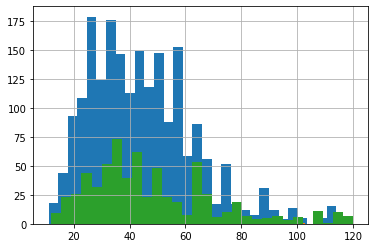

In [23]:
# Train dataset
seq_len_train = [len(bert_tokenizer(sentence)['input_ids']) for sentence in sentences_train]
pd.Series(seq_len_train).hist(bins = 30)
print('Maximum sentence length for train data is {}'.format(max(seq_len_train)))

# Dev dataset
seq_len_dev = [len(bert_tokenizer(sentence)['input_ids']) for sentence in sentences_dev]
pd.Series(seq_len_dev).hist(bins = 30)
print('Maximum sentence length for dev data is {}'.format(max(seq_len_dev)))

# Test dataset
seq_len_test = [len(bert_tokenizer(sentence)['input_ids']) for sentence in sentences_test]
pd.Series(seq_len_test).hist(bins = 30)
print('Maximum sentence length for test data is {}'.format(max(seq_len_test)))

In [24]:
# Define maximum desired length for the sentences
MAX_LENGTH = 120

In [25]:
# Loading the sentences into the BERT Tokenizer
train_inp = []
train_mask = []
for sentence in sentences_train:
    bert_inp = bert_tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, return_attention_mask=True)
    train_inp.append(bert_inp['input_ids'])
    train_mask.append(bert_inp['attention_mask'])

val_inp = []
val_mask = []
for sentence in sentences_dev:
    bert_inp = bert_tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, return_attention_mask=True)
    val_inp.append(bert_inp['input_ids'])
    val_mask.append(bert_inp['attention_mask'])

test_inp = []
test_mask = []
for sentence in sentences_test:
    bert_inp = bert_tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, return_attention_mask=True)
    test_inp.append(bert_inp['input_ids'])
    test_mask.append(bert_inp['attention_mask'])


train_inp = np.asarray(train_inp)
train_mask = np.array(train_mask)
train_label = np.array(labels_train)

val_inp = np.asarray(val_inp)
val_mask = np.asarray(val_mask)
val_label = np.array(labels_dev)

test_inp = np.asarray(test_inp)
test_mask = np.asarray(test_mask)
test_label = np.array(labels_test)


print('[TRAIN] input_ids length: {}.\nattention_masks length: {}.\nlabels length: {}.'.format(len(train_inp), len(train_mask), len(train_label)))
print('[DEV] input_ids length: {}.\nattention_masks length: {}.\nlabels length: {}.'.format(len(val_inp), len(val_mask), len(val_label)))
print('[TEST] input_ids length: {}.\nattention_masks length: {}.\nlabels length: {}.'.format(len(test_inp), len(test_mask), len(test_label)))

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[TRAIN] input_ids length: 2052.
attention_masks length: 2052.
labels length: 2052.
[DEV] input_ids length: 259.
attention_masks length: 259.
labels length: 259.
[TEST] input_ids length: 657.
attention_masks length: 657.
labels length: 657.


In [26]:
# Definition of NUM_CLASSES
NUM_CLASSES = len(RareDis_df_train["Relation"].unique())
print('Nr of classes: {}\n'.format(NUM_CLASSES))

Nr of classes: 5



With the preprocessing done, the declaration of the model is the following step.

In [27]:
# Declaration of the model
model = TFBertForSequenceClassification.from_pretrained("biobert_v1.1_pubmed", num_labels=NUM_CLASSES, from_pt=True)
print("Model charged!")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model charged!


Now the fine-tuning process for the pre-trained BERT model is executed.

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  108310272 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  3845      
Total params: 108,314,117
Trainable params: 108,314,117
Non-trainable params: 0
_________________________________________________________________
Bert Model: None


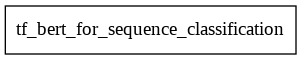

In [28]:
# Setting up the model hyperparameters
BATCH_SIZE = 16
EPOCHS = 25
LOSS = losses.SparseCategoricalCrossentropy(from_logits=True)
METRIC = metrics.SparseCategoricalAccuracy('accuracy')
OPTIMIZER = keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)
#OPTIMIZER = keras.optimizers.SGD(learning_rate=1e-3)

# Compiling the model
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=[METRIC])

# Visualization of the model
print('Bert Model:', model.summary())
plot_model(model, show_shapes=True)

Training the model.

In [29]:
# Definition of the callbacks
es = True # EarlyStopping use
mc = False # ModelCheckpoint use
tb = False # TensorBoard use

my_callbacks = []
if es:
  my_callbacks.append(EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1, restore_best_weights=True))
  print('Used EarlyStopping')
if mc:
  CHECKPOINT_FILEPATH = root+'/relation_extraction/checkpoints/'+'bert.h5'
  my_callbacks.append(ModelCheckpoint(filepath=CHECKPOINT_FILEPATH, monitor='val_loss', mode='min', verbose=1, save_best_only=True))
  print('Used ModelCheckpoint')
if tb:
  import datetime, os
  logdir = os.path.join(root+'/relation_extraction/logs/fit/', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  my_callbacks.append(TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_images=False))
  %tensorboard --logdir /content/drive/MyDrive/Colab\ Notebooks/relation_extraction/logs # to monitor the training in progress
  print('Used TensorBoard')

# Training the model
history = model.fit([train_inp, train_mask], train_label, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=([val_inp, val_mask], val_label), callbacks=my_callbacks)

Used EarlyStopping
Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the func

This step is optional and it is used to visualize the training of the network.

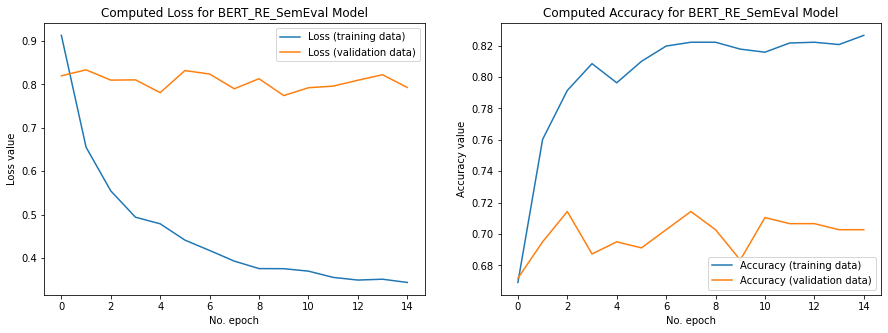

In [30]:
# Define figure
fig_results = plt.figure(figsize=(15, 5))
ax_loss = fig_results.add_subplot(1, 2, 1)
ax_accuracy = fig_results.add_subplot(1, 2, 2)

# Plot history: Loss
ax_loss.plot(history.history['loss'], label='Loss (training data)')
ax_loss.plot(history.history['val_loss'], label='Loss (validation data)')
ax_loss.set_title('Computed Loss for BERT_RE_SemEval Model')
ax_loss.set_ylabel('Loss value')
ax_loss.set_xlabel('No. epoch')
ax_loss.legend(loc="upper right")

# Plot history: Accuracy
ax_accuracy.plot(history.history['accuracy'], label='Accuracy (training data)')
ax_accuracy.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
ax_accuracy.set_title('Computed Accuracy for BERT_RE_SemEval Model')
ax_accuracy.set_ylabel('Accuracy value')
ax_accuracy.set_xlabel('No. epoch')
ax_accuracy.legend(loc="lower right")
plt.show()

## 4. Evaluation and metrics

First, we compute the accuracy of the trained model in terms of validation and test.

In [31]:
# Scores of the accuracy of trained network in validation
validation_scores = model.evaluate([val_inp, val_mask], val_label, verbose=2)
print("Validation loss:", validation_scores[0])
print("Validation accuracy:", validation_scores[1])

# Scores of the accuracy of trained network in test
test_scores = model.evaluate([test_inp, test_mask], test_label, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

9/9 - 4s - loss: 0.7742 - accuracy: 0.6834
Validation loss: 0.7741562724113464
Validation accuracy: 0.6833977103233337
21/21 - 10s - loss: 0.8217 - accuracy: 0.7199
Test loss: 0.8217344880104065
Test accuracy: 0.719939112663269


For the evaluation of the model, accuracy alone doesn’t truly reflect the performance of our model, so we use the predict function, which outputs the probability for each class. The index of the maximum corresponds to the actual prediction. Two implementations:
- Case 1: If the current trained model is the one to be evaluated.
- Case 2: If a previous trained model is to be loaded and evaluated.

In [32]:
# Definition of the current model is to be evaluated
current_model_evaluated = True # Defined by user

if current_model_evaluated:
  # Predictions of the trained network in validation
  prediction_probabilities_validation = model.predict([val_inp, val_mask])
  predictions_validation = [np.argmax(pred) for pred in prediction_probabilities_validation.logits] # predictions represented as integer category
  y_true_validation = [value for value in val_label] # actual values represented as integer category
  
  # Predictions of the trained network in test
  prediction_probabilities_test = model.predict([test_inp, test_mask])
  predictions_test = [np.argmax(pred) for pred in prediction_probabilities_test.logits] # predictions represented as integer category
  y_true_test = [value for value in test_label] # actual values represented as integer category
  print('Current model evaluation finished')

else:
  trained_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=NUM_CLASSES)
  trained_model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=[METRIC])
  trained_model.load_weights(CHECKPOINT_FILEPATH)

  # Predictions of the trained network in validation
  prediction_probabilities_validation = trained_model.predict([val_inp, val_mask])
  predictions_validation = [np.argmax(pred) for pred in prediction_probabilities_validation.logits] # predictions represented as integer category
  y_true_validation = [value for value in val_label] # actual values represented as integer category

  # Predictions of the trained network in test
  prediction_probabilities_test = trained_model.predict([input_ids_test, attention_masks_test])
  predictions_test = [np.argmax(pred) for pred in prediction_probabilities_test.logits] # predictions represented as integer category
  y_true_test = [value for value in labels_test] # actual values represented as integer category
  print('Loaded model evaluation finished')

Current model evaluation finished


The confusion matrix and the classification report are then displayed. They presents the precision, recall and f1 score for each class.

1.   Confusion Matrix representation

Each line corresponds to the true label and each column to the prediction. The scale bar is expressed as percentages.

Confusion matrix in validation:
[[126   6   5   4   2]
 [  4   1   4   1   1]
 [ 23   0  35   9   1]
 [  8   0   3  12   2]
 [  4   0   5   0   3]]
Confusion matrix in test:
[[363   6  27   9   3]
 [ 15  10   3   1   0]
 [ 64   4  64  19   3]
 [ 23   0   4  24   0]
 [  1   0   2   0  12]]


Text(0.5, 1.0, 'Confusion Matrix for Test')

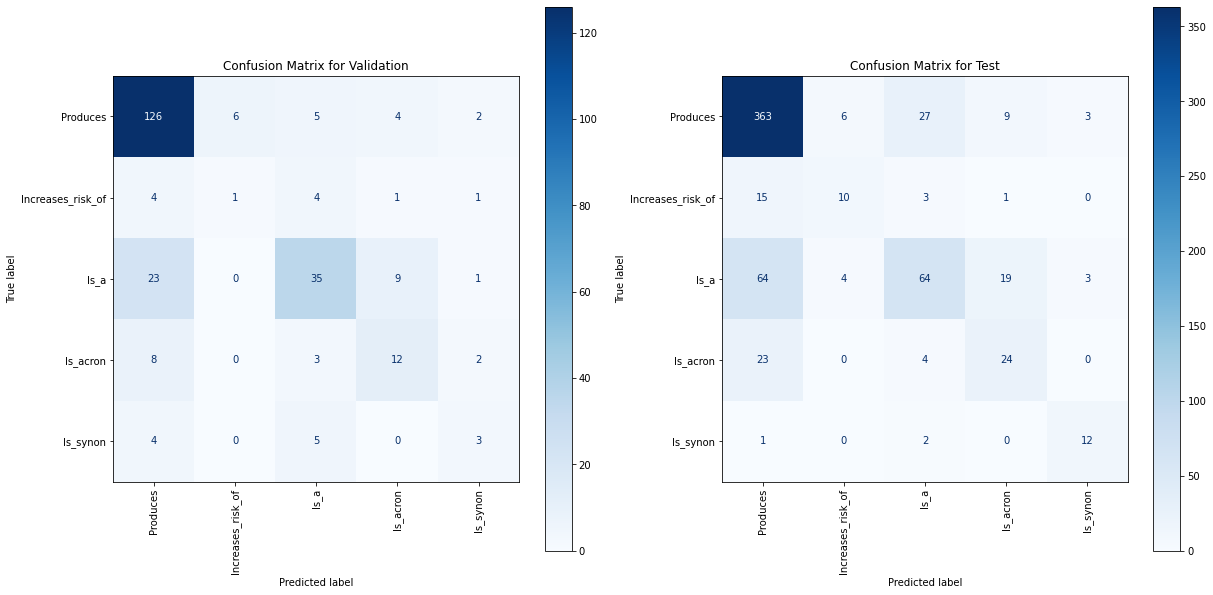

In [33]:
relations = ['Produces',
            'Increases_risk_of',
            'Is_a',
            'Is_acron',
            'Is_synon',        
]

# Calculating Confusion Matrix in validation
cm_val = confusion_matrix(y_true_validation, predictions_validation)
print('Confusion matrix in validation:', cm_val, sep='\n')

# Calculating Confusion Matrix in test
cm_test = confusion_matrix(y_true_test, predictions_test)
print('Confusion matrix in test:', cm_test, sep='\n')

# Visualizing both Confusion Matrix
fig_cm = plt.figure(figsize=(20,10))
ax1_cm = fig_cm.add_subplot(1,2,1)
ax2_cm = fig_cm.add_subplot(1,2,2)
ConfusionMatrixDisplay(cm_val, display_labels=relations).plot(cmap='Blues', xticks_rotation='vertical', values_format='', ax=ax1_cm)
ConfusionMatrixDisplay(cm_test, display_labels=relations).plot(cmap='Blues', xticks_rotation='vertical', values_format='', ax=ax2_cm)
ax1_cm.set_title('Confusion Matrix for Validation')
ax2_cm.set_title('Confusion Matrix for Test')

2.   Classification report representation

Builds a text report showing the main classification metrics.



In [34]:
print('Classification report in validation:', classification_report(y_true_validation, predictions_validation, digits=4), sep='\n')
print('Classification report in test:', classification_report(y_true_test, predictions_test, digits=4), sep='\n')

Classification report in validation:
              precision    recall  f1-score   support

           0     0.7636    0.8811    0.8182       143
           1     0.1429    0.0909    0.1111        11
           2     0.6731    0.5147    0.5833        68
           3     0.4615    0.4800    0.4706        25
           4     0.3333    0.2500    0.2857        12

    accuracy                         0.6834       259
   macro avg     0.4749    0.4433    0.4538       259
weighted avg     0.6644    0.6834    0.6683       259

Classification report in test:
              precision    recall  f1-score   support

           0     0.7790    0.8897    0.8307       408
           1     0.5000    0.3448    0.4082        29
           2     0.6400    0.4156    0.5039       154
           3     0.4528    0.4706    0.4615        51
           4     0.6667    0.8000    0.7273        15

    accuracy                         0.7199       657
   macro avg     0.6077    0.5841    0.5863       657
weighted 